# Feature Engineering
Carefully teasing out patterns in the corpus is a key part of natural language processing. Cleaning is all done, so now it's time to get things that a human speaker would know out of the data.

In [16]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Since the train test split script is part of the data pipeline, I'm reassembling the corpus here
train = pd.read_csv('../assets/train.csv', index_col=0)
test = pd.read_csv('../assets/test.csv', index_col = 0)
df = pd.concat([train, test], axis = 0)

## Vocables: Non-lexical words
Turkish songs use certain sounds that don't carry strict lexical meaning, but are expressions of grief or are just good musical material. We should include some scripting to figure out if there's any pattern in the use of these vocables. I've picked 5 common vocables: `oy`, `ah`, `ey`, `vay`, and `oh`. For each, I'm making a column for the total amount of characters that each song spends on these vocables as well as replacing them in the corpus.

In [18]:
# First the vocable patterns: each vocable can have 1+ of all the characters in it, with the h's optional
vocable_patterns = {
    'oy':r'\bo+y+\b',
    'ah':r'\ba+h*\b',
    'ey':r'\be+y+\b',
    'vay':r'\bva+y+\b',
    'oh':r'\bo+h*\b'
}

In [19]:
# Next the counter. For each key in the dictionary above this loop makes a new column.
for key, value in vocable_patterns.items():
    def vocable_counter(text, vocable_pattern = value):
        list_of_vocables = re.findall(vocable_pattern, text.lower())
        if list_of_vocables != None:
            len_voc = 0
            for match in list_of_vocables:
                len_voc += len(match)
            return len_voc
        else:
            return 0
    df['longest_'+key] = df['text'].map(vocable_counter)

In [20]:
# Finally, a loop to replace all the long drawn out vocables with a simple short version
for key, value in vocable_patterns.items():
    def vocable_encoder(text, vocable_pattern = value):
        list_of_vocables = re.findall(vocable_pattern, text.lower())
        if list_of_vocables != None:
            for match in list_of_vocables:
                text = re.sub(match, key, text.lower())
            return text
        else:
            return text
    df['text'] = df['text'].map(vocable_encoder)

In [21]:
df.loc[38252,'text']

'i̇nsanlar kendini bilebilseydi dünyada haksızlık kavga ohlmazdı i̇nsan dohğan yine insan ölseydi belki de dünyada hayvan kalmazdı hayvanlar yabanda sürüsüyünen geçinemez biri birisiyen i̇nsan cennetinin hurisiyinen sevişseydi hak yabana salmazdı tüm canların hak ohlduğun bilmese hakkın aşkı yüreğine dohlmasa oh güzel cemale aşık ohlmasa kul garibim bu sazını çalmazdı söz&müzik neşet ertaş'

In [22]:
df['text'] = df['text'].map(lambda x: re.sub('i̇', 'i', x))

## Some other simple features
- longest word
- total words
- how many words are repeated
- how many bigrams are repeated
- most common bigram

In [23]:
def find_longest_word(text):
    """Finds the longest word in a lyric"""
    r = 0
    for i in text.split():
        if len(i) > r:
            r = len(i)
    return r

In [24]:
df['longest_word'] = df['text'].map(find_longest_word)

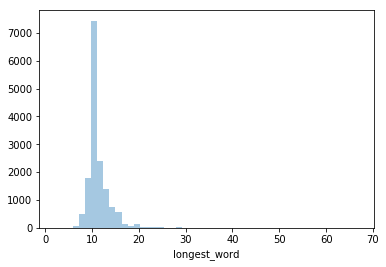

In [25]:
sns.distplot(df['longest_word'], kde = False)

In [26]:
df['total_words'] = df['text'].map(lambda x: len(x.split()))

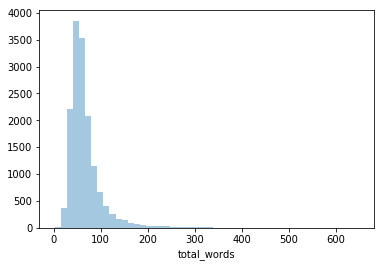

In [27]:
sns.distplot(df['total_words'], kde = False)

In [28]:
def count_repeated_words(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    count = 0
    for word in list(set(text)):
        count += (text.count(word) - 1)
    return count

In [29]:
def make_bigrams(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    return [(i, j) for i,j in zip(text[:-1], text[1:])]
        

In [30]:
def count_repeated_bigrams(text):
    bigrams = make_bigrams(text)
    count = 0
    for bigram in list(set(bigrams)):
        count += (bigrams.count(bigram) - 1)
    return count

In [31]:
df['repeated_exact_words'] = df['text'].map(count_repeated_words)

In [32]:
df['repeated_bigrams'] = df['text'].map(count_repeated_bigrams)

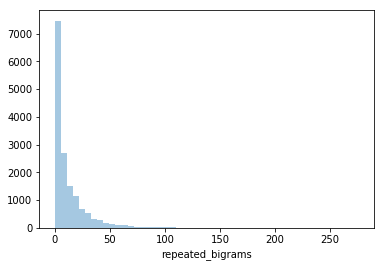

In [33]:
sns.distplot(df['repeated_bigrams'], kde = False)

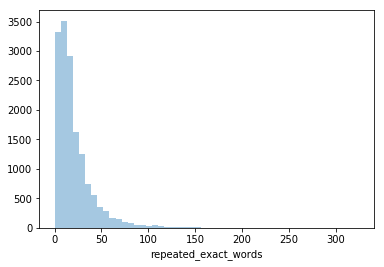

In [34]:
sns.distplot(df['repeated_exact_words'], kde = False)

In [35]:
def get_most_common_bigram(text):
    bigrams = make_bigrams(text)
    most = 0
    most_common_bigram = None
    for bigram in list(set(bigrams)):
        if (bigrams.count(bigram) - 1) > most:
            most = (bigrams.count(bigram) - 1)
            most_common_bigram = bigram
    if most > 1:
        return most_common_bigram
    else:
        return None

In [36]:
df['most_common_bigram'] = df['text'].map(get_most_common_bigram)

In [38]:
df['most_common_bigram']

10852           (dağlar, dağlar)
38749               (gel, gülüm)
21715               (en, delisi)
44202               (dur, gitme)
36383          (geceler, sessiz)
30555                       None
11116              (lazım, seni)
19553             (bir, cebimde)
26722          (yalancı, gülüşe)
55028                       None
52887                 (bir, yol)
2636                        None
38303                       None
52891                       None
40819                       None
45551                       None
24226                (ne, zaman)
37130                       None
49226                       None
35187                       None
48252                       None
20398                       None
54041                       None
1326                        None
19857                       None
39540                       None
11081                       None
46362                 (mü, dedi)
1382                        None
23376                       None
          

In [39]:
temp_df = pd.DataFrame(df['most_common_bigram'].value_counts())

In [40]:
temp_df.head(20)

,most_common_bigram
"(aman, aman)",69
"(gel, gel)",35
"(oy, oy)",35
"(bir, gün)",32
"(yar, yar)",28
"(vay, vay)",28
"(bu, gece)",23
"(beni, beni)",20
"(ben, seni)",20
"(nenni, nenni)",18


In [41]:
aman_aman = df[df['most_common_bigram'] == ('aman', 'aman')]

In [44]:
1 - aman_aman['written_precoup'].mean()

0.6666666666666667